# Variational Autoencoder Tutorial in TensorFlow 
## David Zoltowski

The tutorial is organized in the following manner:
1. Set-up: importing packages, data, defining useful functions, and parameter settings
2. Building the computational graph: defining the series of operations we perform on an input. This is where we build the encoder and decoder networks and implement the reparametrization trick. Additionally, we define the loss function used to optimize the parameters of the graph.
3. Training the model: we train the model using stochastic gradient descent on mini-batches of data, optimizing the loss function. 
4. Visualization: visualize the trained models ability to reconstruct test images and sampling new images from the prior.

### 1. Set-up.

First, import the necessary packages, numpy and tensorflow, and the data on which we will train the model, MNIST.

In [65]:
import numpy as np 
import tensorflow as tf

# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


When defining the model we will define many sets of weight and bias parameters (variables). I have copied this function from the TensorFlow website to define normal distributed weight variables, truncated at 2 standard deviations, and constant bias variables. From the TensorFlow website: "Variables allow us to add trainable parameters to a graph. They are constructed with a type and initial value" e.g. tf.Variable([0.0],dtype=tf.float32).

In [66]:
# define functions to create weight and bias variables, from TensorFlow.org
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

The final part of the set-up is to define the size of different parts of our network. We specifiy the input size to be the length of a image stacked into a vector, the number of hidden units in each of our hidden layers, and the dimensionality of the latent space.

In [94]:
latent_dim = 20; # size of latent space
input_size = 784; # size of input image vector
hidden_size = 500; # size of hidden layers in neural network

### 2. Building the computational graph.

We use the placeholder construct in TensorFlow to parametrize the graph to accept inputs (TensorFlow.org). The placeholders fixes a node in the computational graph with no value, but a value which we will specify later. 

We define the placeholder with the type of input, here a floating point tf.float32, and size of input. Our input to placeholders will be a mini-batch of images. We specify the size following the TensorFlow webiste: "We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of floating-point numbers, with a shape [None, 784]. (Here None means that a dimension can be of any length.)"

In [95]:
x = tf.placeholder(tf.float32, shape=[None, 784])

The next stage of the VAE is to build the decoder network, inference network, or approximate posterior. This network will map the image vector to two vectors of size "latent_dim": a mean vector and a log variance vector. 

I created a network with two hidden layers. I defined two sets of hidden layer weights, W1 and W2, and two sets of hidden layer biases, b1 and b2. The weights are matrices with dimensionality "input layer x current layer" and the biases are vectors with dimensionality "current layer". For each layer, I used the "tf.matmul" function to multiply the preceding input and the weight matrices, and then added the biases. Finally, I passed the sum W \* x + b through a sigmoidal nonlinearity using "tf.nn.sigmoid".

In [96]:
# encoder network
W1 = weight_variable([input_size,hidden_size])
b1 = bias_variable([hidden_size])
h1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)
W2 = weight_variable([hidden_size,hidden_size])
b2 = bias_variable([hidden_size])
h2 = tf.nn.sigmoid(tf.matmul(h1,W2) + b2)

Now we need to read out the second hidden layer to the mean vector and log variance vector. I introduce two more sets of weights and biases corresponding to each output vector. The output vectors are not passed through a nonlinearity. I chose to output the log variance so that I did not have to worry about positivity constraints. 

In [97]:
# get mean
W_hidden_mean = weight_variable([hidden_size, latent_dim])
b_hidden_mean = bias_variable([latent_dim])
hidden_mean = tf.matmul(h2, W_hidden_mean) + b_hidden_mean

# get sigma - log variances
W_hidden_sigma = weight_variable([hidden_size, latent_dim])
b_hidden_sigma = bias_variable([latent_dim])
hidden_log_sigma_sqr = tf.matmul(h2, W_hidden_sigma) + b_hidden_sigma

The preceding layers will output a mean vector and log variance vector for every input image in the batch, corresponding to the mean and variance parameters of the approximate posterior for each image. We will train the parameters of the variatonal autoencoder - both the parameters of the approximate posterior q(z|x) and generative model p(x|z) which we have yet to define - using stochastic estimates of the evidence lower bound (ELBO): E_q(z|x)[log p(x|z)] - D_KL[q(z|x)||p(z)], where p(z) is N(0,I). 

We will estimate the ELBO expectation using one sample from q(z|x) for each data point. This is where we use the reparametrization trick obtain lower variance gradients. Instead, we will draw noise eps from a zero mean, identity covariance Gaussian and map it to a sample from each q(z|x) using the mean and log variance vectors: z = mu + eps.\* variance.

We draw a noise vector eps and map it to a sample from the posterior q(z|x) for each input image x in the mini-batch with the following lines of code.

In [98]:
# sample noise with same shape as log variance vectors
eps = tf.random_normal(tf.shape(hidden_log_sigma_sqr), 0, 1, dtype=tf.float32)

# get a sample from the approximate posterior for each input
# add mean and the std (sqrt of the exponentiated log variances) pointwise times noise
hidden_sample = hidden_mean + tf.multiply(tf.sqrt(tf.exp(hidden_log_sigma_sqr)),eps)

Now that we have a sample z from the approximate posterior q(z|x), we pass z through a decoder network to reconstruct the image. I defined the decoder network similarly to the same way as the encoder network, with two hidden layers. However, this time the input to the network is of dimensionality "latent_dim" and the output of dimension 784 x 1, the image size, is passed through a sigmoidal function to be in [0,1].

In [99]:
# decoder network - map the hidden sample to an output of size = image size
W3 = weight_variable([latent_dim,hidden_size])
b3 = bias_variable([hidden_size])
h3 = tf.nn.sigmoid(tf.matmul(hidden_sample, W3) + b3)
W4 = weight_variable([hidden_size,hidden_size])
b4 = bias_variable([hidden_size])
h4 = tf.nn.sigmoid(tf.matmul(h3,W4) + b4)

# output x_hat, the reconstruction mean
W_out = weight_variable([hidden_size,input_size])
b_out = bias_variable([input_size])
x_hat = tf.nn.sigmoid(tf.matmul(h4, W_out) + b_out)

The last part of the computational graph that we need to specify is the training objective. The objective consists of two parts: the reconstruction loss - corresponding go log p(x|z) - and the KL divergence D_KL( q(z|x) || p(z) ).

I will set the reconstruction loss to be the sum of squared errors between each pixel of the input image x and output of the network x_hat. This corresponds to log p(x|z) up to an additive constant when p(x|z) is N(mu(z),I).

In [114]:
# reconstruction loss is squared error between reconstruction and image (MLE in N(mu(x),sigma^2 I))
reconstruction_loss = tf.reduce_sum(tf.square(x-x_hat)/0.5,1)

A loss that I have observed being used is the cross entropy of the output reconstruction and the true image value, which is mathematically equivalent to the Bernoulli log likelihood of each pixel of image x given each parameter x_hat. However, we are confused as to why this loss is being use, as the pixel values are not binary.

In [115]:
# another loss people use is the cross entropy of the output reconstruction and true image value
# reconstruction loss is Bernoulli log likelihood of each pixel of image x given x hat (output of decoder)
#reconstruction_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_hat) + (1-x) * tf.log(1e-10 + 1 - x_hat),1)

The KL divergence between two normal distributions q(z|x) and p(z) has an exact form.

In [116]:
# KL divegence between the approximate posterior and prior
kl_divergence = -0.5 * tf.reduce_sum(1 + hidden_log_sigma_sqr - tf.square(hidden_mean) - tf.exp(hidden_log_sigma_sqr), 1)

The training objective "loss" is the mean of the reconstruction loss and KL divergence loss across the images in the mini-batch. We will train the variables in our model to minimize the loss, using the tf.train API. I have defined a training step below which will use the Adam optimizer.

In [117]:
# avg_loss is the mean across images x in the batch
loss = tf.reduce_mean(reconstruction_loss + kl_divergence);

# train step
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

### Training the model.

In [118]:
# saver to save model
saver = tf.train.Saver()

# train network
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
n_samples = mnist.train.num_examples
# Training cycle
training_epochs = 25
batch_size = 100
display_step = 1
for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        x_batch = mnist.train.next_batch(batch_size)
        current_loss = loss.eval(feed_dict={x:x_batch[0]}) #/ n_samples * batch_size
        # Compute average loss
        avg_loss += current_loss / n_samples * batch_size
        # Fit training using batch data
        train_step.run(feed_dict={x: x_batch[0]})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), 
            "loss=", "{:.9f}".format(avg_loss))

#saver.save(sess, 'davidz_vae_150_epochs')

Epoch: 0001 loss= 101.369989416
Epoch: 0002 loss= 72.494008068
Epoch: 0003 loss= 61.933768602
Epoch: 0004 loss= 57.390836743
Epoch: 0005 loss= 54.656759859
Epoch: 0006 loss= 52.454970662
Epoch: 0007 loss= 51.096203794
Epoch: 0008 loss= 49.920904652
Epoch: 0009 loss= 49.094208506
Epoch: 0010 loss= 48.398590615
Epoch: 0011 loss= 47.734167328
Epoch: 0012 loss= 47.240967955
Epoch: 0013 loss= 46.658125097
Epoch: 0014 loss= 46.365933019
Epoch: 0015 loss= 46.085416912
Epoch: 0016 loss= 45.591980778
Epoch: 0017 loss= 45.252513469
Epoch: 0018 loss= 45.162862327
Epoch: 0019 loss= 44.792972690
Epoch: 0020 loss= 44.571408816
Epoch: 0021 loss= 44.363225209
Epoch: 0022 loss= 44.083604958
Epoch: 0023 loss= 43.973190072
Epoch: 0024 loss= 43.600231039
Epoch: 0025 loss= 43.436257081


In [34]:
#saver = tf.train.import_meta_graph('davidz_vae_150_epochs.meta')
#saver.restore(sess,tf.train.latest_checkpoint('./'))

### Visualization

This piece of code takes a test image from MNIST (x_sample) and evaluates the reconstruction x_hat when x_sample is fed into the VAE. 

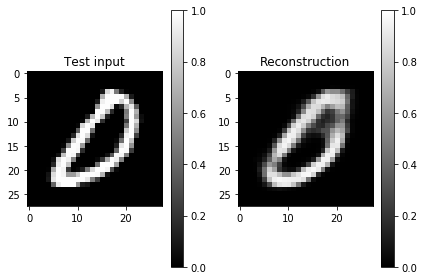

In [120]:
# reconstruct
import matplotlib.pyplot as plt
%matplotlib inline
x_sample = mnist.test.next_batch(1)[0]
x_reconstruct = x_hat.eval(feed_dict={x:x_sample})
plt.figure
plt.subplot(1, 2, 1)
plt.imshow(x_sample.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.title("Test input")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(x_reconstruct.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.title("Reconstruction")
plt.colorbar()
plt.tight_layout()

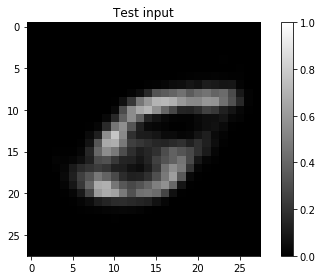

In [128]:
# generate
eps = np.random.normal(0,1,size=latent_dim)
eps = np.array(eps).reshape(1,latent_dim)
import matplotlib.pyplot as plt
%matplotlib inline
x_reconstruct = x_hat.eval(feed_dict={hidden_sample:eps})
plt.figure
plt.imshow(x_reconstruct.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.title("Test input")
plt.colorbar()
plt.tight_layout()


In [ ]:
# to add normalizing flows, need to estimate entropy of log posterior rather than compute KL explicitly, 
# compute probability of latent variable explicitly rather than in KL, 
# compute Jacobian determinant terms for penalizing ELBO
# ensure flows are parametrized in a good way